In [1]:
from __future__ import annotations

import os
import sys
import time
import copy
import yaml
import logging
import argparse

import numpy as np
import torch
import pytest

from ase import Atoms, units
from ase.md.langevin import Langevin
from ase.io import read, write
from ase.constraints import FixAtoms
from ase.calculators.calculator import Calculator, all_changes
from ase.stress import full_3x3_to_voigt_6_stress
from ase.calculators.singlepoint import SinglePointCalculator as sp

from tqdm import tqdm
import pytorch_lightning as pl

from matsciml.common.registry import registry
from matsciml.common.utils import radius_graph_pbc, setup_imports, setup_logging
from matsciml.datasets.transforms import (
    PeriodicPropertiesTransform,
    PointCloudToGraphTransform,
    FrameAveraging,
)
from matsciml.datasets.trajectory_lmdb import data_list_collater
from matsciml.lightning import MatSciMLDataModule
from matsciml.models.pyg import FAENet
from matsciml.models.base import ForceRegressionTask
from matsciml.models.utils.io import multitask_from_checkpoint
from matsciml.preprocessing.atoms_to_graphs import *


In [2]:
checkpoint_path = "/home/m3rg2000/Simulation/checkpoints-2024/FAENet_250k.ckpt"
Loaded_model = multitask_from_checkpoint(checkpoint_path)

In [3]:
a2g=AtomsToGraphs(max_neigh=200,
            radius=6,
            r_energy=False,
            r_forces=False,
            r_distances=False,
            r_edges=True,
            r_fixed=True,)
f_avg=FrameAveraging(frame_averaging="3D", fa_method="stochastic")

def convAtomstoBatch(atoms):
    data_obj=a2g.convert(atoms)
    Reformatted_batch={
        'cell' : data_obj.cell,
        'natoms' :  torch.Tensor([data_obj.natoms]).unsqueeze(0),
        'edge_index' : [data_obj.edge_index.shape],
        'cell_offsets': data_obj.cell_offsets,
        'y' : None,
        'force' : None, 
        'fixed' : [data_obj.fixed],
        'tags' : None,
        'sid' :None,
        'fid' : None,
        'dataset' : 'S2EFDataset',
        'graph' : data_list_collater([data_obj]),
    }
    Reformatted_batch=f_avg(Reformatted_batch)
    return Reformatted_batch


In [4]:

class FAENet_ASEcalculator(Calculator):
    """Simulation ASE Calculator"""

    implemented_properties = ["energy", "free_energy", "forces", "stress"]

    def __init__(
        self,
        model,
        **kwargs
    ):
        Calculator.__init__(self, **kwargs)
        self.results = {}

        self.model = model
        
        
    # pylint: disable=dangerous-default-value
    def calculate(self, atoms=None, properties=None, system_changes=all_changes):
        """
        Calculate properties.
        :param atoms: ase.Atoms object
        :param properties: [str], properties to be computed, used by ASE internally
        :param system_changes: [str], system changes since last calculation, used by ASE internally
        :return:
        """
        # call to base-class to set atoms attribute
        Calculator.calculate(self, atoms)

        # prepare data
        batch=convAtomstoBatch(atoms)

        # predict + extract data
        out = self.model(batch)
        energy = out['force_regression0']["energy"].detach().cpu().item()
        forces = out['force_regression0']["force"].detach().cpu().numpy()
        stress = out['force_regression0']["stress"].squeeze(0).detach().cpu().numpy()
        # store results
        E = energy
        stress= np.array([stress[0, 0],
                                   stress[1, 1],
                                   stress[2, 2],
                                   stress[1, 2],
                                   stress[0, 2],
                                   stress[0, 1]])
        self.results = {
            "energy": E,
            # force has units eng / len:
            "forces": forces,
            "stress" : stress,
        }


In [5]:
def FIRE_Relax(atoms, calculator, NStep=1e4, ftol=1e-5,plot=False):
    atoms.set_calculator(calculator)
    optimizer = FIRE(atoms)
    trajectory = []
    energies = []
    def record_trajectory():
        trajectory.append(atoms.copy())
        energies.append(atoms.get_potential_energy())
    optimizer.attach(record_trajectory, interval=1)
    optimizer.run(fmax=ftol,steps=NStep)
    
    if(plot):
        # Plotting energy vs. optimization step
        plt.figure()
        plt.plot(energies)
        plt.xlabel('Optimization Step')
        plt.ylabel('Energy (eV)')
        plt.title('Energy vs. Optimization Step')
        plt.grid(True)
        plt.show()
    return trajectory, energies

    

/home/m3rg2000/Simulation/NPT_Env/matsciml/matsciml/preprocessing/atoms_to_graphs.py:355: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987290837/work/torch/csrc/utils/tensor_new.cpp:275.)
  cell = torch.Tensor(atoms.get_cell()).view(1, 3, 3)
/home/m3rg2000/miniconda3/envs/matsciml/lib/python3.9/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987290837/work/aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


      Step     Time          Energy         fmax
FIRE:    0 12:13:58        3.696498        0.0371
FIRE:    1 12:13:58        3.689008        0.0693
FIRE:    2 12:13:58        3.689156        0.0709
FIRE:    3 12:13:58        3.696038        0.0346
FIRE:    4 12:13:59        3.699845        0.0400
FIRE:    5 12:13:59        3.699249        0.0438
FIRE:    6 12:13:59        3.685448        0.0824
FIRE:    7 12:13:59        3.688039        0.0918
FIRE:    8 12:13:59        3.681027        0.1028
FIRE:    9 12:13:59        3.682376        0.1171
FIRE:   10 12:13:59        3.678166        0.1286


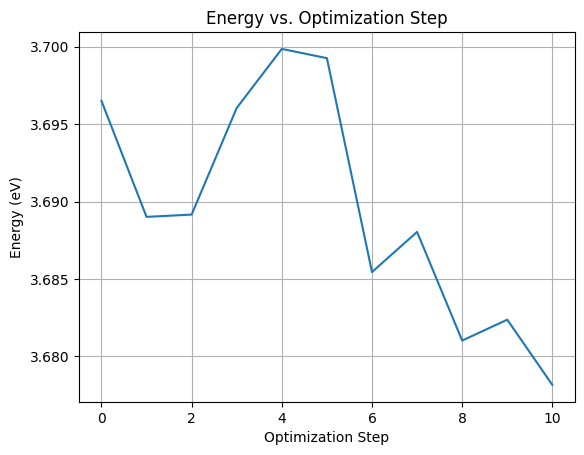

In [6]:
import time
from ase.io import read
from ase.optimize import FIRE
from ase.calculators.calculator import Calculator
import matplotlib.pyplot as plt

start_time = time.time()
calculator = FAENet_ASEcalculator(Loaded_model)
cif_file_path = "/home/m3rg2000/Simulation/checkpoints-2024/SiO2.cif"
atoms = read(cif_file_path)
OptimTraj, OptimEnergies=FIRE_Relax(atoms, calculator, NStep=10, ftol=1e-5,plot=True)